# **Experiment: Using voting regressor**

# **Set-up**

In [1]:
%%capture
%pip install setuptools wheel autogluon.tabular[all] dask[dataframe]
%pip install -U -q ipywidgets

In [2]:
%pip install -q catboost lightgbm xgboost optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.5/599.5 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.9 MB/s eta 0:00:00


In [3]:
# Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Ml imports
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from tqdm import tqdm
from autogluon.features.generators import AutoMLPipelineFeatureGenerator
from sklearn.ensemble import VotingRegressor
import pickle
import optuna
from datetime import timedelta

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Functions**

In [5]:
def train_voting_ensemble(X, y, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(X))
    models = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"Training fold {fold + 1}/{n_folds}")

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        voting_regressor = VotingRegressor(
            estimators=[
                ('xgb', XGBRegressor(**xgb_params)),
                ('lgb', LGBMRegressor(**lgb_params)),
                ('cat', CatBoostRegressor(**cat_params))
            ],
            n_jobs=-1
        )
        # Fit voting regressor
        voting_regressor.fit(X_train, y_train)

        # Make predictions
        oof_preds[val_idx] = voting_regressor.predict(X_val)
        models.append(voting_regressor)

        # Calculate fold score
        fold_score = root_mean_squared_error(y_val, oof_preds[val_idx])
        print(f"Fold {fold + 1} RMSE: {fold_score:.4f}")

    # Calculate overall score
    final_score = root_mean_squared_error(y, oof_preds)
    print(f"\nOverall RMSE: {final_score:.4f}")

    return oof_preds, models

# **Feature generation 1**

# **Feature generation**

In [ ]:
#base_path = os.getenv('DATA_FOLDER_PATH', 'Data/')
base_path = os.getenv('DATA_FOLDER_PATH', '/content/drive/MyDrive/DS_Projects/Playground_Series/Ps4e12_Regression_Insuranse_Premium_Prediction/Data/')

train = pd.read_parquet(os.path.join(base_path, 'train_transformed_fe.parquet'))
test = pd.read_parquet(os.path.join(base_path, 'test_transformed_fe.parquet'))
submission = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))

In [ ]:
target_log = train['premium_amount_log']
feature_generator = AutoMLPipelineFeatureGenerator()
train_transformed = feature_generator.fit_transform(train.drop(columns="premium_amount_log"), target_log)
test_transformed = feature_generator.transform(test)
features = train_transformed.columns

print("Features: ", features)
print("Target: ", target_log.head().values)

Features:  Index(['age', 'gender', 'annual_income', 'number_of_dependents',
       'health_score', 'previous_claims', 'vehicle_age', 'credit_score',
       'insurance_duration', 'smoking_status', 'year', 'month', 'day',
       'week_of_year', 'quarter', 'year_sin', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'is_weekend', 'is_month_end', 'is_month_start',
       'is_quarter_end', 'is_quarter_start', 'policy_age_days',
       'week_of_month', 'days_in_month', 'days_remaining_in_month',
       'income_per_dependent', 'total_risk_score', 'claims_to_duration_ratio',
       'vehicle_to_driver_age_ratio', 'is_young_driver', 'lifestyle_score',
       'location_risk', 'location_avg_credit', 'responsibility_score',
       'family_risk_factor', 'asset_risk', 'dependent_income_ratio',
       '4log_WeightedEnsemble_L4', '12nonlog_WeightedEnsemble_L3',
       'xgb_complicated_probs', 'lgb_complicated_probs',
       'xgb_complicated_probs_rank', 'lgb_complicated_probs_rank',
       'marit

In [ ]:
# Add 'Missing' category and fill NaN values for both train and test
categorical_features = [col for col in train_transformed.columns if train_transformed[col].dtype == 'category']
for col in categorical_features:
    # Add 'Missing' to categories
    train_transformed[col] = train_transformed[col].cat.add_categories('Missing')
    test_transformed[col] = test_transformed[col].cat.add_categories('Missing')

    # Now fill NaN values
    train_transformed[col] = train_transformed[col].fillna('Missing')
    test_transformed[col] = test_transformed[col].fillna('Missing')


# **Classifying complicated observations**

In [ ]:
errors = (train_transformed[['4log_WeightedEnsemble_L4']]
          .assign(premium_amount_log = target_log)
          .assign(preds_log = lambda x: np.log1p(x['4log_WeightedEnsemble_L4']))
          .assign(error = lambda x: x['premium_amount_log'] - x['preds_log'])
          .assign(error_squared = lambda x: x['error'] ** 2)
          .sort_values('error_squared', ascending=False)
          .assign(error_pct = lambda x: x['error_squared'] / sum(x['error_squared']))
          .assign(error_pct_cum = lambda x: x['error_pct'].cumsum())
)
errors

,4log_WeightedEnsemble_L4,premium_amount_log,preds_log,error,error_squared,error_pct,error_pct_cum
id,,,,,,,
785472,4.951566,8.495561,1.783654,6.711907,45.049689,1.703535e-06,0.000002
22795,5.113390,8.507345,1.810482,6.696863,44.847979,1.695908e-06,0.000003
1023825,5.115076,8.507345,1.810757,6.696588,44.844285,1.695768e-06,0.000005
161171,4.966532,8.479491,1.786166,6.693325,44.800605,1.694116e-06,0.000007
301681,5.023757,8.482395,1.795711,6.686683,44.711736,1.690756e-06,0.000008
...,...,...,...,...,...,...,...
1071881,6.906054,3.044522,2.067629,0.976894,0.954321,3.608726e-08,1.000000
882130,6.908260,3.044522,2.067908,0.976615,0.953776,3.606666e-08,1.000000
142048,6.912152,3.044522,2.068400,0.976123,0.952815,3.603032e-08,1.000000


In [ ]:
top_errors = errors.query('error_pct_cum < 0.2').index
errors.query('error_pct_cum < 0.2').shape

(151007, 7)

count    151007.000000
mean          7.940090
std           0.191193
min           7.485492
25%           7.787797
50%           7.905810
75%           8.060540
max           8.517193
Name: premium_amount_log, dtype: float64


<Axes: >

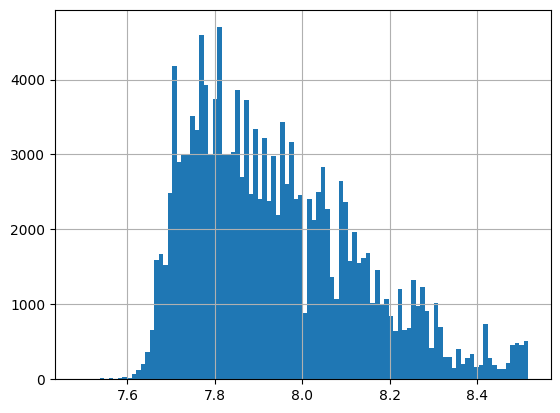

In [ ]:
# Most errors are exclusively concentrated in the lower tail
print(target_log.loc[top_errors].describe())
target_log.loc[top_errors].hist(bins=100)

<Axes: >

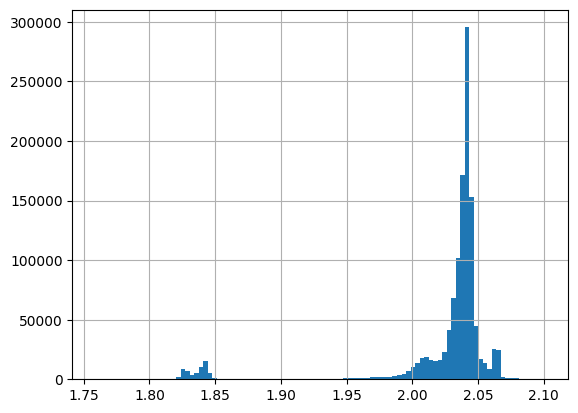

In [ ]:
# Prediction almost exclusively predict over 10000 premium value
(
    train_transformed[['4log_WeightedEnsemble_L4']]
    .assign(preds_log = lambda x: np.log1p(x['4log_WeightedEnsemble_L4']))['preds_log']
    .hist(bins=100)
)

<Axes: >

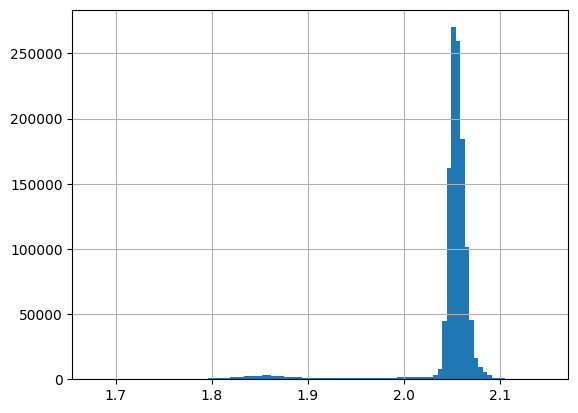

In [ ]:
# Same with the non log model
(
    train_transformed[['12nonlog_WeightedEnsemble_L3']]
    .assign(preds_log = lambda x: np.log1p(x['12nonlog_WeightedEnsemble_L3']))['preds_log']
    .hist(bins=100)
)

In [ ]:
# # Lets define complicated observations
# train_transformed['complicated'] = np.where(target_log < 4, 1, 0)
# train_transformed.groupby('complicated').size()

,0
complicated,
0,1136330
1,63670


# **Voting Regressor**

In [ ]:
# Define base models with their parameters
xgb_params = {
    'n_estimators': 2000,
    'max_depth': 10,
    'colsample_bytree': 0.5,
    'learning_rate': 0.01,
    'tree_method': 'hist',
    'eval_metric': 'rmse',
    'subsample': 0.9,
    'min_child_weight': 10,
    'enable_categorical': True,
    'n_jobs':-1,
    'verbose':-1,
    'gpu_id': '0',
    'tree_method': 'gpu_hist'
}

lgb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "max_depth": 10,
    "num_leaves": 2**10,
    "colsample_bytree": 0.5,
    "eval_metric": "rmse",
    'subsample': 0.90,
    'min_child_samples': 10,
    "verbose":-1,
    'n_jobs':-1
}

cat_params = {
    'depth': 10,
    'learning_rate': 0.01,
    'l2_leaf_reg': 3.5,
    'random_strength': 4,
    'bagging_temperature': 0.25,
    'eval_metric': 'RMSE',
    'loss_function': 'RMSE',
    'cat_features': categorical_features,
    'iterations': 3000,
    'task_type': 'GPU',
    'devices': '0'
}

In [ ]:
ensemble_oof_preds, ensemble_models = train_voting_ensemble(
    train_transformed[features],
    target_log,
    n_folds=5
)

Training fold 1/5
Fold 1 RMSE: 1.0458
Training fold 2/5
Fold 2 RMSE: 1.0448
Training fold 3/5
Fold 3 RMSE: 1.0460
Training fold 4/5
Fold 4 RMSE: 1.0440
Training fold 5/5
Fold 5 RMSE: 1.0455

Overall RMSE: 1.0452


# **Submission**

In [ ]:
submission = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))

In [ ]:
test_predictions = np.zeros(len(test_transformed))

for model in ensemble_models:
    test_predictions += np.maximum(0, np.expm1(model.predict(test_transformed))) / len(ensemble_models)


submission['Premium Amount'] = test_predictions
submission.to_csv(os.path.join(base_path, 'submissions/submission_voting_regressor.csv'), index = False)
submission.head()

,id,Premium Amount
0,1200000,910.581638
1,1200001,640.408348
2,1200002,720.147305
3,1200003,752.712875
4,1200004,597.737702


In [ ]:
# convert ensemble_oof_preds to dataframe
ensemble_oof_preds_df = pd.DataFrame(ensemble_oof_preds, columns=['ensemble_oof_preds'])
ensemble_oof_preds_df.to_parquet(os.path.join(base_path, 'oofs/oofs_voting_regressor.parquet'))

with open(os.path.join(base_path, 'voting_regressor_models.pkl'), 'wb') as f:
    pickle.dump(ensemble_models, f)

# **Feature Generation 2**

In [6]:
#base_path = os.getenv('DATA_FOLDER_PATH', 'Data/')
base_path = os.getenv('DATA_FOLDER_PATH', '/content/drive/MyDrive/DS_Projects/Playground_Series/Ps4e12_Regression_Insuranse_Premium_Prediction/Data/')

train = pd.read_csv(os.path.join(base_path, 'train.csv'))
test = pd.read_csv(os.path.join(base_path, 'test.csv'))
submission = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))

In [7]:
train.set_index('id', inplace=True)
test.set_index('id', inplace=True)

# Renaming columns for consistency
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()
train.columns = [col.replace(" ", "_") for col in train.columns]
test.columns = [col.replace(" ", "_") for col in test.columns]

In [8]:
def feature_transformer(df):

    df['policy_start_date'] = pd.to_datetime(df['policy_start_date'])

    df['year'] = df['policy_start_date'].dt.year
    df['day'] = df['policy_start_date'].dt.day
    df['month'] = df['policy_start_date'].dt.month
    df['day_of_year'] = df['policy_start_date'].dt.dayofyear
    df['day_of_week'] = df['policy_start_date'].dt.weekday
    df['sin_day_of_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['cos_day_of_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    df["seconds since 1970"] = df['policy_start_date'].astype("int64") // 10**9

    df['days_passed'] = (df['policy_start_date'].max() - df['policy_start_date']).dt.days

    df['cat_day_of_week'] = df['day_of_week'].astype('string')
    df['cat_year'] = df['year'].astype('string')
    df['cat_day'] = df['day'].astype('string')
    df['cat_day_of_year'] = df['day_of_year'].astype('string')
    df['cat_month'] = df['month'].astype('string')


    policy_starts_min = df['policy_start_date'].min()  # 2019-08-17
    year = policy_starts_min.year

    if policy_starts_min >= pd.Timestamp(f'{year}-01-01'):
        fiscal_year_start = pd.Timestamp(f'{year}-08-01')
    else:
        fiscal_year_start = pd.Timestamp(f'{year-1}-08-01')


    df['time_from_fiscal_year'] = (df['policy_start_date'] - fiscal_year_start).dt.days
    df['seconds_from_fiscal_year'] = (df['policy_start_date'] - fiscal_year_start).dt.total_seconds()

    new_date = policy_starts_min - timedelta(days=1)

    df['time_from_first_policy'] = (df['policy_start_date'] - new_date).dt.days

    df['time_from_first_policy_seconds'] = (df['policy_start_date'] - new_date).dt.total_seconds()

    df['Days Passed'] = (df['policy_start_date'].max() - df['policy_start_date']).dt.days

    df['claims_vs_duration'] = df['previous_claims'] / df['insurance_duration']
    df['days_from_2019_crisis'] = (df['policy_start_date'] - pd.Timestamp('2019-01-01')).dt.days
    df['revenue_per_dependent'] = (df['annual_income'] / df['number_of_dependents'] + 1)
    df['ratio_of_doubts'] = (df['previous_claims'] + 1) / df['annual_income'] # NEW

    df['marital_status_customer_feedback'] = df['marital_status'] + df['customer_feedback']
    df['customer_feedback_property_type'] = df['customer_feedback'] + df['property_type']
    df['customer_feedback_year'] = df['customer_feedback'] + df['cat_year'] # тут упала
    df['marital_status_year'] = df['marital_status'] + df['cat_year']
    df['exercise_frequency_year'] = df['exercise_frequency'] + df['cat_year']
    df['customer_feedback_smoking_status'] = df['customer_feedback'] + df['smoking_status']
    df['customer_feedback_property_type'] = df['customer_feedback'] + df['property_type']
    df['year_day_of_week'] = df['cat_year'] + df['cat_day_of_week']
    df['property_type_year'] = df['property_type'] + df['cat_year']
    df['policy_type_year'] = df['policy_type'] + df['cat_year']
    df['gender_marital_status'] = df['gender'] + df['marital_status']
    df['education_level_customer_feedback'] = df['education_level'] + df['customer_feedback']
    df['gender_year'] = df['gender'] + df['cat_year']
    df['marital_status_day_of_week'] = df['marital_status'] + df['cat_day_of_week']
    df['occupation_customer_feedback'] = df['occupation'] + df['customer_feedback']
    df['occupation_year'] = df['occupation'] + df['cat_year']
    df['location_customer_feedback'] = df['location'] + df['customer_feedback']
    df['location_day_of_week'] = df['location'] + df['cat_day_of_week']
    df['education_level_year'] = df['education_level'] + df['cat_year']
    df['customer_feedback_month'] = df['customer_feedback'] + df['cat_month']
    df['marital_status_day'] = df['marital_status'] + df['cat_day']
    df['exercise_frequency_property_type'] = df['exercise_frequency'] + df['property_type']
    df['education_level_day_of_week'] = df['education_level'] + df['cat_day_of_week']

    df.drop(columns=['time_from_first_policy', 'policy_start_date'], inplace=True)

    return df

In [9]:
def columns_imputer(df):
    for c in df.columns:
        df[f"is_{c}_na"] = df[c].isna().astype(int)

    return df

In [10]:
num_cols = ['age', 'annual_income', 'number_of_dependents', 'health_score','previous_claims', 'vehicle_age', 'credit_score', 'insurance_duration']

for col in num_cols:
    print(f"Column {col} has {train[train[col] == 0].shape[0]} zeros")

Column age has 0 zeros
Column annual_income has 0 zeros
Column number_of_dependents has 218124 zeros
Column health_score has 0 zeros
Column previous_claims has 305433 zeros
Column vehicle_age has 61615 zeros
Column credit_score has 0 zeros
Column insurance_duration has 0 zeros


In [11]:
def num_to_cat(df):
    global num_cols

    for col in num_cols:
        df[f"categorial_{col}"] = df[col].astype('category')

    return df

In [12]:
# Train Transformation
X = train.drop('premium_amount', axis=1)
y = train['premium_amount']

y_log1p = np.log1p(y)

X = feature_transformer(X)
X = columns_imputer(X)
X = num_to_cat(X)

cats = X.select_dtypes(include=['string', 'category', 'object']).columns.tolist()
nums = X.select_dtypes(include=['number']).columns.tolist()

for col in cats:
    X[col] = X[col].astype('string')

X[cats] = X[cats].fillna('None').astype('string')
X[nums] = X[nums].fillna(-999).astype(float)
cat_features = X.select_dtypes(include=['category', 'string', 'object']).columns.tolist()

In [13]:
# Test transformation
X_test = feature_transformer(test)
X_test = columns_imputer(X_test)
X_test = num_to_cat(X_test)

cats = X_test.select_dtypes(include=['string', 'category', 'object']).columns.tolist()
nums = X_test.select_dtypes(include=['number']).columns.tolist()

for col in cats:
    X_test[col] = X_test[col].astype('string')

X_test[cats] = X_test[cats].fillna('None').astype('string')
X_test[nums] = X_test[nums].fillna(-999).astype(float)

In [14]:
feature_generator = AutoMLPipelineFeatureGenerator()
X_train_transformed = feature_generator.fit_transform(X, y_log1p)
X_test_transformed = feature_generator.transform(X_test)

In [15]:
# Add 'Missing' category and fill NaN values for both train and test
categorical_features = [col for col in X_train_transformed.columns if X_train_transformed[col].dtype == 'category']
for col in categorical_features:
    # Add 'Missing' to categories
    X_train_transformed[col] = X_train_transformed[col].cat.add_categories('Missing')
    X_test_transformed[col] = X_test_transformed[col].cat.add_categories('Missing')

    # Now fill NaN values
    X_train_transformed[col] = X_train_transformed[col].fillna('Missing')
    X_test_transformed[col] = X_test_transformed[col].fillna('Missing')

In [16]:
numeric_columns = X_train_transformed.select_dtypes(['float64', 'float32', 'int64', 'int32']).columns
X_train_transformed[numeric_columns] = X_train_transformed[numeric_columns].replace([np.inf, -np.inf], np.nan)
X_train_transformed[numeric_columns] = X_train_transformed[numeric_columns].fillna(-999)

X_test_transformed[numeric_columns] = X_test_transformed[numeric_columns].replace([np.inf, -np.inf], np.nan)
X_test_transformed[numeric_columns] = X_test_transformed[numeric_columns].fillna(-999)


In [21]:
# train_transformed = pd.concat([X_train_transformed, y_log1p], axis=1)
# train_transformed.to_csv(os.path.join(base_path, 'train_transformed_fg2.csv'))

# test_transformed = X_test_transformed
# test_transformed.to_csv(os.path.join(base_path, 'test_transformed_fg2.csv'))

## **Voting regressor**

In [17]:
# @title Default title text
# Define base models with their parameters
xgb_params = {
    'n_estimators': 2000,
    'max_depth': 10,
    'colsample_bytree': 0.5,
    'learning_rate': 0.01,
    'tree_method': 'hist',
    'eval_metric': 'rmse',
    'subsample': 0.9,
    'min_child_weight': 10,
    'enable_categorical': True,
    'n_jobs':-1,
    'verbose':-1
}

lgb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "max_depth": 10,
    "num_leaves": 2**10,
    "colsample_bytree": 0.5,
    "eval_metric": "rmse",
    'subsample': 0.90,
    'min_child_samples': 10,
    "verbose":-1,
    'n_jobs':-1
}

cat_params = {
    'depth': 10,
    'learning_rate': 0.01,
    'l2_leaf_reg': 3.5,
    'random_strength': 4,
    'bagging_temperature': 0.25,
    'eval_metric': 'RMSE',
    'loss_function': 'RMSE',
    'cat_features': categorical_features,
    'iterations': 3000
}

In [ ]:
voting_reg_preds, voting_reg_models = train_voting_ensemble(
    X_train_transformed,
    y_log1p,
    n_folds=3
)

Training fold 1/3


# **Submission**

In [ ]:
submission = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))

In [ ]:
test_predictions = np.zeros(len(test_transformed))

for model in voting_reg_models:
    test_predictions += np.maximum(0, np.expm1(model.predict(X_test_transformed))) / len(voting_reg_models)


submission['Premium Amount'] = test_predictions
submission.to_csv(os.path.join(base_path, 'submissions/submission_voting_regressor_fg2.csv'), index = False)
submission.head()

In [ ]:
# convert ensemble_oof_preds to dataframe
ensemble_oof_preds_df = pd.DataFrame(ensemble_oof_preds, columns=['ensemble_oof_preds'])
ensemble_oof_preds_df.to_parquet(os.path.join(base_path, 'oofs/oofs_voting_regressor_fg2.parquet'))

with open(os.path.join(base_path, 'voting_regressor_models_fg2.pkl'), 'wb') as f:
    pickle.dump(ensemble_models, f)